In [1]:
# Использовать решатели:
# glpk                     1
# gurobi                   1
# xpress                   1
# gams                     1
# gdpopt.enumerate         1
# mindtpy.ecp              1
# cbc                      1
# conopt                   25
# copt                     1
# CPLEX                    1
# ilogcp                   1
# loqo                     25
# minos                    25

In [2]:
from generator_d import GeneratorD
from generator_e import GeneratorE
from generator_p import GeneratorP
from generator_t import GeneratorT
from model_builder import ModelBuilder
from solve_action import SolveAction

In [3]:
from ipywidgets import IntProgress
from IPython.display import display

In [4]:
import xpress
inited = xpress.init('/Users/dambr/venv/lib/python3.12/site-packages/xpress/license/community-xpauth.xpr')

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pyomo.environ as pyo

In [6]:
def to_mtx_with_values(A):
    values = A.extract_values()
    (m, k) = np.shape(A)
    result = np.zeros((m, k))
    for i in range(m):
        for j in range(k):
            result[i][j] = round(values[(i, j)])
    return result

In [7]:
def calculate_result_cost(T, D, P, E, A):
    A = to_mtx_with_values(A)
    m = np.shape(A)[0]

    f_in = lambda x: 0 if x == 0 else 1
    f_im = lambda x: 0 if x < 1 else 1

    
    result = 0
    for requirements in E:
        
        files = np.dot(requirements, T)

        f_dep = lambda x: np.dot(files, D) if x == 0 else np.dot(f_dep(x - 1), D)
        files_with_dependencies = files + sum([f_dep(i) for i in range(m)])
        
        plugins = np.dot(files_with_dependencies, A)
        plugins = np.array([f_in(x) for x in plugins])
        
        files_in_delivery = np.dot(A, plugins)
        
        requirements_in_delivery = np.dot(T, files_in_delivery)
        requirements_in_delivery = np.array([f_im(x) for x in requirements_in_delivery])
        
        prices = np.dot(P, requirements_in_delivery)
        
        cost = np.dot(requirements_in_delivery, prices)
        
        result += cost
    return result

In [8]:
def solve(M, k, T, D, P, E, solver_name):
    model_builder = ModelBuilder(M, k, T, D, P, E)
    model = model_builder.build()
    durations = []
    costs = []
    solve_action = SolveAction(model, solver_name)
    count = 100
    progress = IntProgress(min=0, max=count, value=0, description=solver_name, bar_style='success')
    display(progress)
    for i in range(count):
        solve_result = solve_action.solve()
        instance = solve_result.instance
        cost = calculate_result_cost(T, D, P, E, instance.A)
        duration = solve_result.duration
        costs.append(cost)
        durations.append(duration)
        progress.value += 1
    return (durations, set(costs))

In [9]:
M = 10**6

In [10]:
e = 1
n = 5
m = 4
k = 3

In [11]:
T = np.array([
    [  1,   0,   0,   0],
    [0.5, 0.5,   0,   0],
    [  0, 0.5, 0.5,   0],
    [  0,   0, 0.5, 0.5],
    [  0,   0,   0,   1]
])

In [12]:
D = np.array([
    [0, 0, 1, 0],
    [0, 0, 1, 1],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
])

In [13]:
P = np.array([
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1]
])

In [14]:
E = np.array([
    [1, 0, 0, 0, 0]
])

In [15]:
solver_names = ['glpk', 'gurobi', 'xpress', 
           'gams', 'gdpopt.enumerate', 
           'mindtpy.ecp', 'cbc', 'conopt',
           'copt', 'CPLEX', 'ilogcp', 'minos']

In [16]:
def draw_violinplot(dataset):
    data = {}
    for key in dataset:
        result = dataset[key]
        solver_name = key.lower()
        if solver_name.find('.') > -1:
            solver_name = solver_name.split('.')
            solver_name = solver_name[0]
        data[solver_name + str(result[1])] = result[0]
    df = pd.DataFrame(data)
    df_melted = pd.melt(df)
    title = 'Statistic'
    sns.violinplot(x='variable', y='value', data=df_melted, width=1, dodge=False, hue='variable').set(title=title)
    plt.xlabel('Solver{value}')
    plt.xticks(rotation=75)
    plt.ylabel('Time to solve the optimization problem (sec)')

In [17]:
dataset = {}

In [18]:
for solver_name in solver_names:
    result = solve(M, k, T, D, P, E, solver_name)
    dataset[solver_name] = result

IntProgress(value=0, bar_style='success', description='glpk')

IntProgress(value=0, bar_style='success', description='gurobi')

IntProgress(value=0, bar_style='success', description='xpress')

IntProgress(value=0, bar_style='success', description='gams')

IntProgress(value=0, bar_style='success', description='gdpopt.enumerate')

IntProgress(value=0, bar_style='success', description='mindtpy.ecp')

IntProgress(value=0, bar_style='success', description='cbc')

IntProgress(value=0, bar_style='success', description='conopt')

IntProgress(value=0, bar_style='success', description='copt')

IntProgress(value=0, bar_style='success', description='CPLEX')

IntProgress(value=0, bar_style='success', description='ilogcp')

IntProgress(value=0, bar_style='success', description='minos')

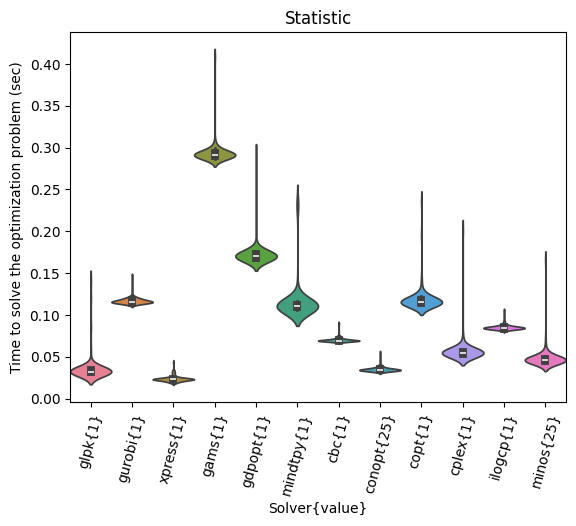

In [19]:
draw_violinplot(dataset)